In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [41]:
import qcodes
qc = qcodes

In [15]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin

In [4]:
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

In [ ]:
# from quantum_capacitance import rf; reload(rf)
# from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [5]:
%run init.py

2018-02-02 11:50:16,391 : measurement : INFO : Logger set up!


Initialized IVVI-rack in 0.34s
Connected to: Keysight Technologies 34465A (serial:MY57503596, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.02s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.05s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.05s


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [6]:
station.ivvi.set_dacs_zero()

In [7]:
from stationq.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

# Definitions

# Experiments

## DC IV traces

In [8]:
from stationq.experiment.measurement import BaseMeasurement

class IVCurve(BaseMeasurement):
    
    start = -150.
    stop = +150
    pts = 151
    
    
#     def postprocess(self):
#         bias = self.data['Current']['Bias [V]'].reshape(-1) * 1e9
#         amp = self.data['Current']['Current [A]'].reshape(-1) * 1e6      
        
    
    def measure(self):
        self.station.key1.NPLC(1)
        vals = []
        bias = np.linspace(self.start, self.stop, self.pts)

        self.station.ivvi.dac1(bias[0])
        time.sleep(1)
        
        for v in bias:
            self.station.ivvi.dac1(v)
            time.sleep(0.01)
            amp = self.station.key1.volt()
            
            self.data.add(
            OrderedDict({
                'Bias' : {'value' : v * 1e-6, "unit": 'V', "independent_parameter": True},
                'Current' : {'value' : amp * 1e-7, "unit": 'A'},
                })
            )
        

In [ ]:
# T = 100
# t0 = time.time()
# delay = 5

m = IVCurve(station, namespace)
m.start = -200
m.stop = 200
m.pts = 2001
m.run()

2018-02-02 13:26:31,273 : measurement : INFO : Ready to measure, file location: d:\data\2018-02\2018-02-02\2018-02-02_IVCurve-#0002...


In [63]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def find_offset(i, v, i_th=0.05, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win))
    v_guess = v[np.argmin(abs(i-i_th))]
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):  
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.

        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    
def fit_linslope(i, v, imin=0.005, imax=0.4):
    i2 = i[(i>imin) & (i<imax)]
    v2 = v[(i>imin) & (i<imax)]
    p = np.polyfit(np.log(i2), v2, 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope

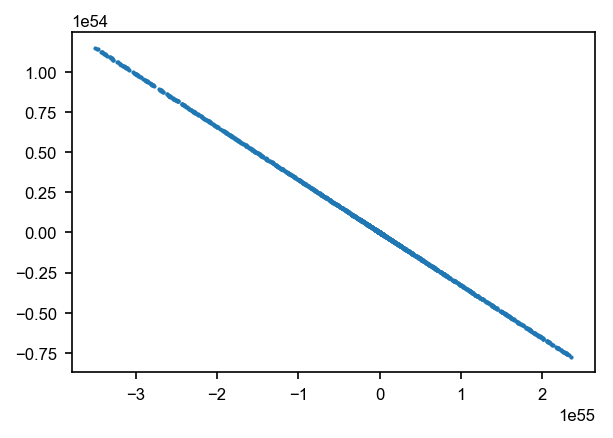

In [68]:
R = 15e3 + 12e3 + 2*1.7e3

v = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()

i -= i[i.size//2]
v -= i*R
v *= 1e6
i *= 1e9

i_of, v_of = find_offset(i, v)
i -= i_of
v -= v_of

# vfit, ifit, T = fit_linslope(i, v)

fig, ax = plt.subplots(1, 1)
ax.plot(v, i, 'o', ms=1)
# ax.plot(vfit, ifit)
# ax.set_yscale('log')

# print(T)

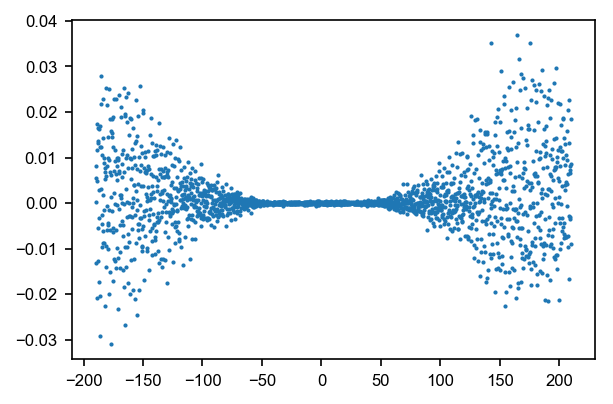

In [52]:
difg = np.diff(i)

fig, ax = plt.subplots(1, 1)
ax.plot(v[:-1], difg, 'o', ms=1)

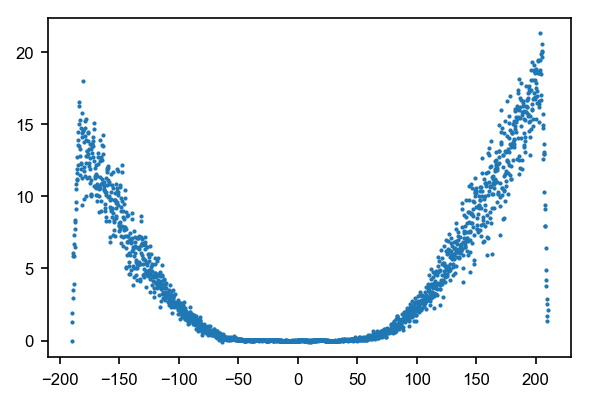

In [58]:
ismooth = smooth(i, 50)
difg = np.diff(ismooth * 1e-9) / np.diff(v * 1e-6)
fig, ax = plt.subplots(1, 1)
ax.plot(v[:-1], difg * 1e6, 'o', ms=1)

In [42]:
S1_gain = 1 # for now 
NW_gain = 1e7 # Gain of current amp in V/A
V_range = 1e-3 #Gain factor of voltage source module in V/V

NW_res = 26400 + NW_gain*1e-4+100

In [43]:
print(NW_res)

27500.0
